In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import copy
pd.set_option('display.max_columns', None)
from pandas.io.json import json_normalize


# Testing testing github 
from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
# load business and user data
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  
# preprocessed review file with reviews only for restaurants 
with open('dataset/restaurant_reviews_trimmed.json') as f:
    review_data = [json.loads(line) for line in f]

# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

# convert array to list
restaurant_reviews = review_data[0] 

# pandas dataframe of restaurant data
restaurant_df = json_normalize(restaurant_data)

## Part 1: Create a Baseline

Our first model was a simple baseline approach, written out as 

$$ \hat{Y}_{um} = \hat{\mu} + \hat{\theta}_{u} + \hat{\gamma}_m $$

where $\hat{\theta}_{u}$ and $\hat{\gamma}_m$ indicate the deviations of user $u$ and restaurant $m$ from some intercept paramter $\mu$. The baseline estimates we used in $\hat{\theta}_{u}$ and $\hat{\gamma}_m$ were the global averages, as seen and explained further below.

### Creating training, validating, and testing sets

In [3]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

As the dataset is so large, we had to take a subset of it to work with because of technical limitations of our computers.

In [4]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In the original dataset, "categories" is given as a list in each cell. We found all the unique categories here (e.g. French, Burgers, etc.).

In [5]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]

Many of the categories were either inappropriate (e.g. laundry) or too rare to be useful. Here, we narrowed down the categories to the top 150.

In [6]:
# create restaurant and user dictionaries for easy lookup
restaurant_dict = {}
for item in restaurant_data:
    restaurant_id = item['business_id']
    restaurant_dict[restaurant_id] = item

user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item
    
# make copy of the reviews array
expanded_reviews = copy.deepcopy(data_array)

In [8]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

Here, we added user and business attributes to the reviews dictionary.

In [9]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

We decided to change "U_yelping_since", which was a year, to the number of years a user has been active (so that it would make more sense as a continuous variable).

In [11]:
# drop ids
flatframe_wids = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

This was just for convenience when performing regression later==we didn't want to use the drop function every time we referred to the dataframe.

In [12]:
#one hot encode
flatframe_wids = pd.get_dummies(flatframe_wids, columns = ['R_state', 
                                                    'R_attributes.Alcohol', 'R_attributes.AgesAllowed', 'R_attributes.RestaurantsAttire',
                                                    'R_attributes.RestaurantsPriceRange2','R_attributes.Smoking',
                                                    'R_attributes.WiFi', 'R_attributes.NoiseLevel','R_attributes.BYOBCorkage'])

In [13]:
# drop column if more than half of a column is nan
nan_count = {}
for column in flatframe_wids:
     nan_count[column] = flatframe_wids[column].isnull().sum()

nan_sorted = sorted(nan_count.items(), key=lambda x: x[1], reverse = True) 
drop_nans = [x[0] for x in nan_sorted if x[1] > 50000]

In [14]:
# drop some nans and fill some nans
flatframe_wids = flatframe_wids.drop(drop_nans, axis = 1)
flatframe_wids = flatframe_wids.fillna(flatframe_wids.mean())

There were many attributes with an unusually large number of NaNs (not 0 or False). We used mean imputation for many of these, but if more than half of the rows had missing values, we felt uncomfortable doing so and decided to drop the column entirely instead.

In [15]:
# train test split
msk = np.random.rand(len(flatframe_wids)) < 0.5
data_train = flatframe_wids[msk]
data_test = flatframe_wids[~msk]

### Getting global averages

In [16]:
# make pandas dataframe for user data
user_df = json_normalize(user_data)

# train test split including business ids and user ids
data_train_temp = flatframe[msk]
data_test_temp = flatframe[~msk]

For this part of the project, we needed to include business and user ids for lookup purposes, which we had earlier deleted.

In [18]:
# global user average
users = data_train_temp.user_id.unique()
user_total = user_df[user_df['user_id'].isin(users)]['average_stars']
global_user_average = sum(user_total)/len(user_total)
print ("The global user average is {}".format(global_user_average))

# global restaurant average
restaurants = data_train_temp.business_id.unique()
restaurant_total = restaurant_df[restaurant_df['business_id'].isin(restaurants)]['stars']
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)
print ("The global restaurant average is {}".format(global_restaurant_average))

# global review average
global_review_average = data_train['stars'].mean()
print ("The global review average is {}".format(global_review_average))

The global user average is 3.7280291378075754
The global restaurant average is 3.5649292823467786
The global review average is 3.708529901832855


The "global user average" takes a single user and his/her average rating given as one data point. The 'global restaurant average' does the same with individual restaurants. The 'global review average' averages every rating from every review. These are different values as each individual rating is weighted differently in each method.

### Getting restaurant and user biases

In [21]:
# user biases
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average

In [22]:
# restaurant biases
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

We decided to use the global user average and the global restaurant average for the user and restaurant bias calculation respectively (rather than global review average for everything) because we felt that it was most appropriate to compare a user's average rating to other users and a restaurant's average rating to other restaurants rather than to an average of all reviews.

### Baseline Model

In [23]:
# creating xy variables
Xtrain = data_train.drop(['stars'], axis = 1)
ytrain = data_train['stars']
Xtest = data_test.drop(['stars'], axis = 1)
ytest = data_test['stars']

In [24]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return int(round(pred))

In [25]:
# predictions
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]

In [26]:
print ("The accuracy score of the baseline model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, base_pred)))
print ("The accuracy score of the baseline model on the test set is {}"
       .format(metrics.accuracy_score(ytest, base_pred_test)))

The accuracy score of the baseline model on the train set is 0.3930700821070805
The accuracy score of the baseline model on the test set is 0.38866638770996476


In [27]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : base_pred})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : base_pred_test})

base_pred_avg = []
base_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    base_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    base_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

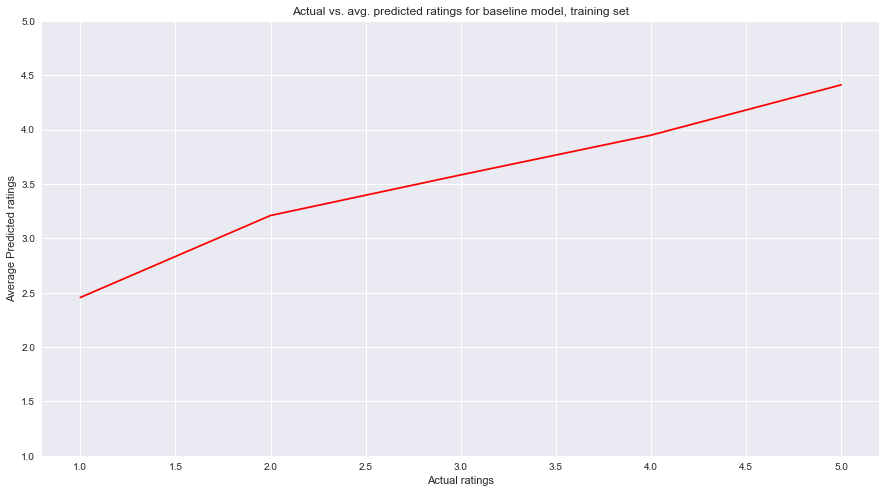

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], base_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, training set')
ax.set_ylim((1,5));

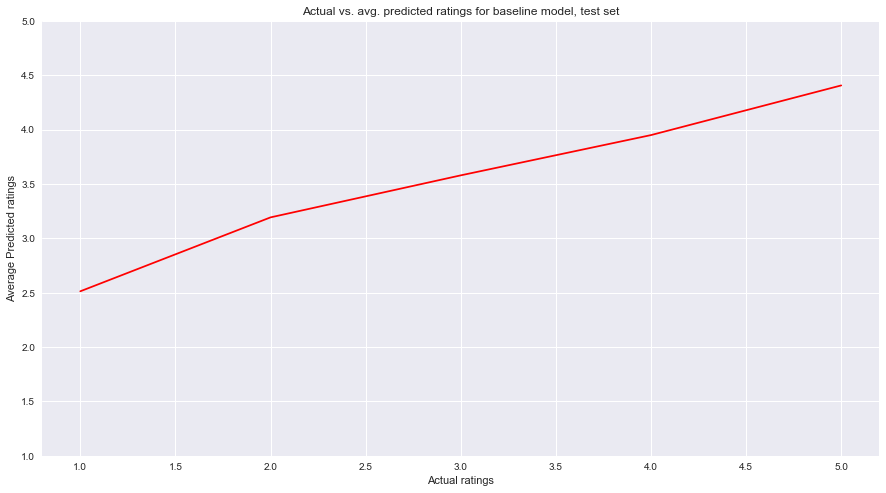

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], base_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, test set')
ax.set_ylim((1,5));

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings.